<a href="https://colab.research.google.com/github/asthakalita22/deepfake-detection/blob/main/deepfake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras opencv-python matplotlib scikit-learn kagglehub

import os, glob, cv2, numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"asthakalita22","key":"34ae9260fa1be3ba2c73639df60e271d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import kagglehub
path = kagglehub.dataset_download("xdxd003/ff-c23")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'ff-c23' dataset.
Path to dataset files: /kaggle/input/ff-c23


In [ ]:
data_dir = os.path.join(path, "FaceForensics++_C23")

categories = {
    "DeepFakeDetection": 1,
    "Deepfakes": 1,
    "Face2Face": 1,
    "FaceShifter": 1,
    "FaceSwap": 1,
    "NeuralTextures": 1,
    "original": 0
}

data = []
for folder, label in categories.items():
    folder_path = os.path.join(data_dir, folder)
    all_videos = glob.glob(os.path.join(folder_path, "*.mp4"))

    if label == 1:
        sampled = all_videos[:200]  # 200 from each fake category
    else:
        sampled = all_videos[:1000]  # 1000 real
    for v in sampled:
        data.append({"File Path": v, "label": label})

balanced_df = pd.DataFrame(data)
print(balanced_df["label"].value_counts())
print("Total selected:", len(balanced_df))


label
1    1200
0    1000
Name: count, dtype: int64
Total selected: 2200


In [ ]:
train_df, test_df = train_test_split(
    balanced_df, test_size=0.2, stratify=balanced_df["label"], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["label"], random_state=42
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 1408 Val: 352 Test: 440


REAL frame dtype: uint8 min: 0 max: 0
FAKE frame dtype: uint8 min: 0 max: 0


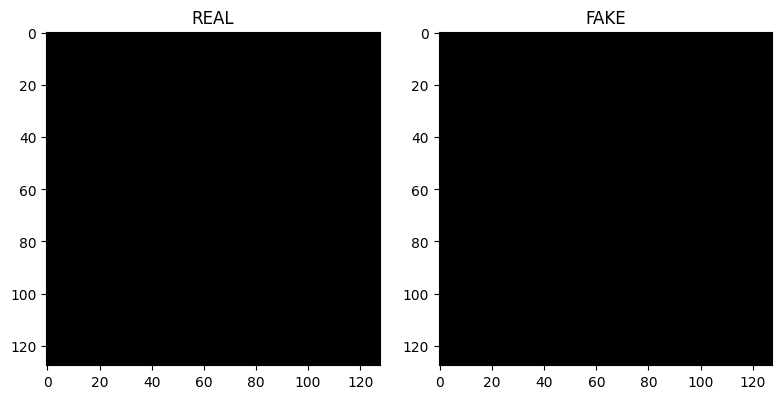

In [ ]:
import os, cv2, numpy as np
from tqdm import tqdm

save_dir = "/content/frames_dataset"
os.makedirs(save_dir, exist_ok=True)

def extract_and_save_frames(df, split_name, num_frames=5):
    split_dir = os.path.join(save_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting {split_name}"):
        video_path = row["File Path"]
        label = str(row["label"])
        label_dir = os.path.join(split_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total == 0:
            continue

        frame_idxs = np.linspace(5, total - 5, num_frames).astype(int)
        frames = []
        for idx in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (128,128))
                frames.append(frame)
        cap.release()
        if len(frames) > 0:
            mean_frame = np.mean(frames, axis=0).astype(np.uint8)
            out_path = os.path.join(label_dir, os.path.basename(video_path).replace(".mp4", ".jpg"))
            cv2.imwrite(out_path, mean_frame)

# Run once
extract_and_save_frames(train_df, "train")
extract_and_save_frames(val_df, "val")
extract_and_save_frames(test_df, "test")



Extracting test: 100%|██████████| 440/440 [19:09<00:00,  2.61s/it]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add augmentations to training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "/content/frames_dataset/train",
    target_size=(128,128),
    batch_size=16,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    "/content/frames_dataset/val",
    target_size=(128,128),
    batch_size=16,
    class_mode='binary'
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/frames_dataset/train'

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Check label assignments visually
print(balanced_df.groupby("label")["File Path"].apply(lambda x: x.iloc[0]))


label
0                                      /kaggle/input/ff-c23/FaceForensics++_C23/original/123.mp4
1    /kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/02_09__kitchen_pan__9TDCEK1Q.mp4
Name: File Path, dtype: object


In [ ]:
# Show 5 examples from each label
pd.set_option('display.max_colwidth', None)

for label in balanced_df['label'].unique():
    print(f"\nLabel {label} examples:")
    print(balanced_df[balanced_df['label'] == label].head(5)['File Path'].to_list())



Label 1 examples:
['/kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/02_09__kitchen_pan__9TDCEK1Q.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/02_13__exit_phone_room__CP5HFV3K.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/24_10__walking_down_street_outside_angry__356HPS7R.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/09_14__talking_angry_couch__6TEK3ZX0.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/20_03__hugging_happy__Z6V05FXO.mp4']

Label 0 examples:
['/kaggle/input/ff-c23/FaceForensics++_C23/original/123.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/original/738.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/original/479.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/original/660.mp4', '/kaggle/input/ff-c23/FaceForensics++_C23/original/565.mp4']


In [ ]:
print("Train set:", np.bincount(train_df['label']))
print("Val set:", np.bincount(val_df['label']))
print("Test set:", np.bincount(test_df['label']))


Train set: [640 768]
Val set: [160 192]
Test set: [200 240]


In [ ]:
batch_size = 16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "/content/frames_dataset/train",
    target_size=(128,128),
    batch_size=16,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    "/content/frames_dataset/val",
    target_size=(128,128),
    batch_size=16,
    class_mode='binary'
)


from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[reduce_lr],
    verbose=1
)





Found 957 images belonging to 2 classes.
Found 318 images belonging to 2 classes.
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 523ms/step - accuracy: 0.6356 - loss: 0.6364 - val_accuracy: 0.5031 - val_loss: 0.7094 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 532ms/step - accuracy: 0.6795 - loss: 0.6045 - val_accuracy: 0.5031 - val_loss: 0.7235 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 539ms/step - accuracy: 0.6620 - loss: 0.6063 - val_accuracy: 0.5314 - val_loss: 0.7383 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 541ms/step - accuracy: 0.7156 - loss: 0.5861 - val_accuracy: 0.5440 - val_loss: 0.7231 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 515ms/step - accuracy: 0.7188 - loss: 0.5861 - val_accuracy: 0.5975 - val_loss: 0.6813 - learning_rate: 5.0000e-05
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 566ms/step - accuracy: 0.7654 - loss: 0.5554 - val_accuracy: 0.5943 - val_loss: 0.6840 - learning_rate: 5.0000e-05
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 533ms/step - accuracy: 0.73

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "/content/frames_dataset/test",
    target_size=(128,128),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}")


Found 382 images belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8707 - loss: 0.4243
Test Accuracy: 0.6257


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.3).astype(int)
y_true = test_gen.classes

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
spec = tn / (tn + fp)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall (Sensitivity): {rec:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix [[TN FP][FN TP]]: [[{tn}, {fp}], [{fn}, {tp}]]")


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 575ms/step
Accuracy: 0.6387
Precision: 0.6158
Recall (Sensitivity): 0.6429
Specificity: 0.6350
F1 Score: 0.6290
ROC-AUC: 0.7115
Confusion Matrix [[TN FP][FN TP]]: [[127, 73], [65, 117]]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "/content/frames_dataset/test",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Predict probabilities
y_pred_prob = model.predict(test_gen)
y_test = test_gen.classes



Found 382 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 570ms/step


In [ ]:
for t in [0.3, 0.35, 0.4, 0.45, 0.5]:
    y_pred = (y_pred_prob > t).astype(int)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Threshold={t:.2f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")


Threshold=0.30  Acc=0.639  Prec=0.616  Rec=0.643  F1=0.629
Threshold=0.35  Acc=0.628  Prec=0.649  Rec=0.478  F1=0.551
Threshold=0.40  Acc=0.628  Prec=0.700  Rec=0.385  F1=0.496
Threshold=0.45  Acc=0.623  Prec=0.771  Rec=0.297  F1=0.429
Threshold=0.50  Acc=0.626  Prec=0.882  Rec=0.247  F1=0.386


In [1]:
!git clone https://github.com/asthakalita22/deepfake-detection.git

Cloning into 'deepfake-detection'...
